<a href="https://colab.research.google.com/github/juliambr/lectures_demos/blob/main/lecture_ai%20evaluation_241107.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to deep learning for medical imaging by [MD.ai](https://www.md.ai)

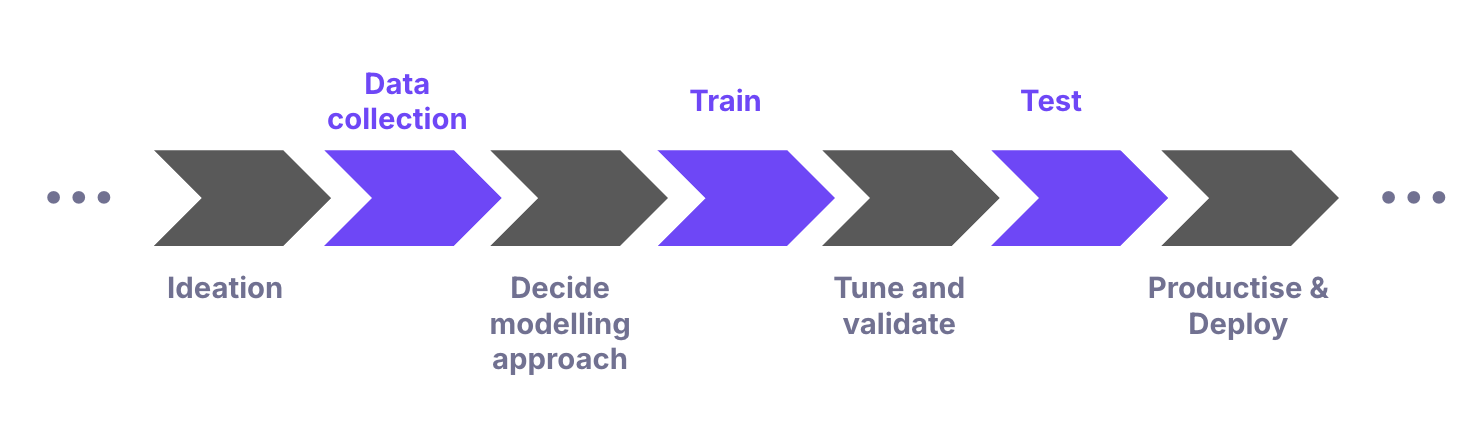

## 1. Idea

#### 💭 Classification of chest vs. adominal X-rays 💭



---


## 2. Data Collection

#### ⏩ Get access to data via the `mdai` library ⏩

In [18]:
pip install -q -U mdai

In [26]:
import mdai
mdai.__version__

'0.15.0'

In [27]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="1b61616ec7ef9c50af6792f666c30a29")

Successfully authenticated to public.md.ai.


In [28]:
p = mdai_client.project('PVq9raBJ', path='./lesson1-data')

Using path './lesson1-data' for data.
Preparing annotations export for project PVq9raBJ...                                                
Using cached annotations data for project PVq9raBJ.
Preparing images export for project PVq9raBJ...                                                     
Using cached images data for project PVq9raBJ.


In [29]:
p.show_label_groups()

Label Group, Id: G_BdW4M5, Name: Default group
	Labels:
	Id: L_38Y7Jl, Name: Abdomen
	Id: L_z8xEkB, Name: Chest



In [30]:
# this maps label ids to class ids as a dict obj
labels_dict = {
    'L_38Y7Jl': 0, # Abdomen
    'L_z8xEkB': 1, # Chest
}

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_38Y7Jl': 0, 'L_z8xEkB': 1}


In [31]:
p.show_datasets()

Datasets:
Id: D_8ogmzN, Name: TRAIN
Id: D_OoJ98E, Name: VAL
Id: D_8oAvmQ, Name: TEST
Id: D_oW0PwQ, Name: TEST2



In [32]:
# create training dataset
train_dataset = p.get_dataset_by_name('TRAIN')
train_dataset.prepare()
train_image_ids = train_dataset.get_image_ids()
print(len(train_image_ids))

# create the validation dataset
val_dataset = p.get_dataset_by_name('VAL')
val_dataset.prepare()
val_image_ids = val_dataset.get_image_ids()
print(len(val_image_ids))

65
10


#### 👀 Display a few images 👀

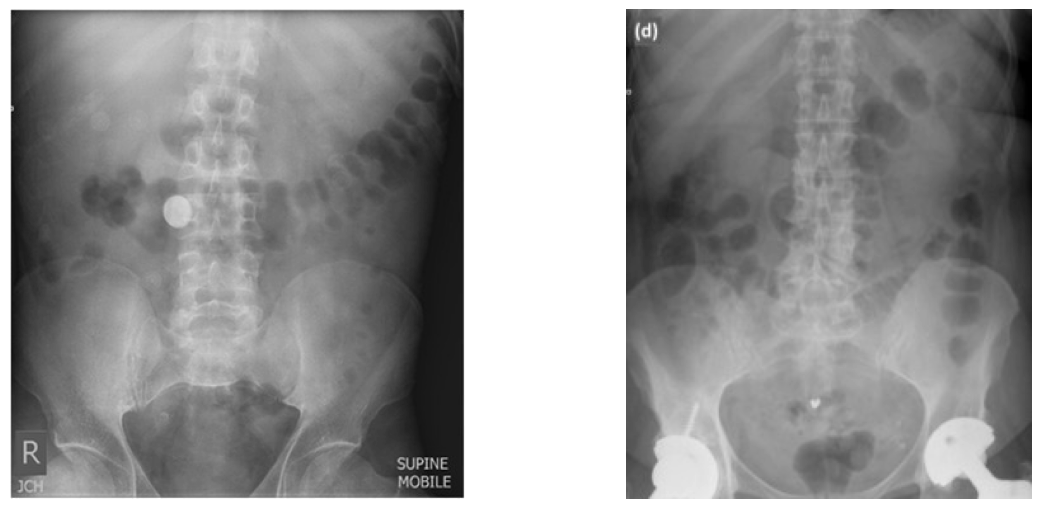

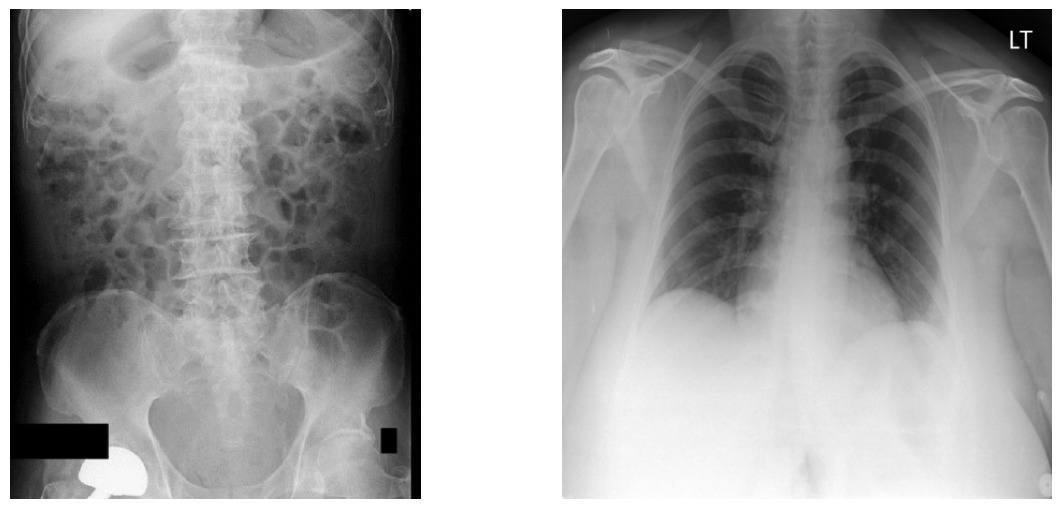

In [33]:
# visualize a few train images
mdai.visualize.display_images(train_image_ids[:2], cols=2)
mdai.visualize.display_images(val_image_ids[:2], cols=2)

---

## 3. Decide modelling approach





#### ⏩ Use tf.keras for training and validation ⏩

In [45]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [46]:
import tensorflow as tf

print(tf.__version__)
tf.keras.backend.clear_session()

2.17.0


In [47]:
# Define model parameters
img_width = 224
img_height = 224
epochs = 100

params = {
    'dim': (img_width, img_height),
    'batch_size': 5,
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': True,
}

In [39]:
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False,
                                             input_shape=(img_width, img_height, 3))

output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(2, activation='softmax')(output)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,230,914 (12.32 MB)

 Trainable params: 3,209,026 (12.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

### 👀 My model chosen: CNN 👀



In [44]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,648,968 (36.81 MB)

 Trainable params: 3,209,026 (12.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 6,418,054 (24.48 MB)

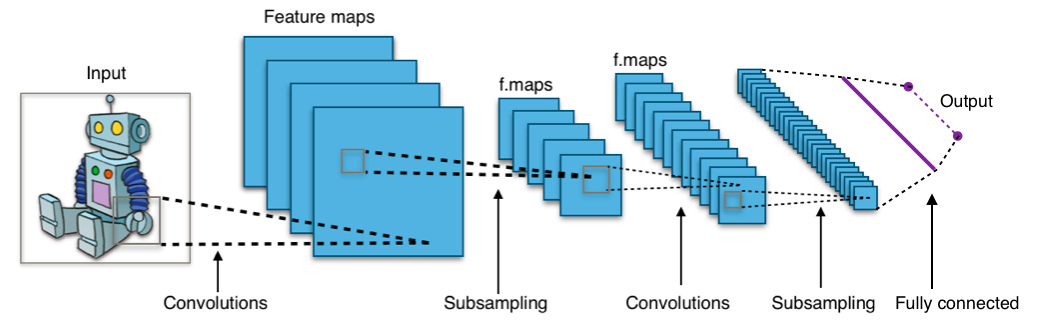

---

## 4. Train

#### ⏩ Define the training pipeline ⏩

In [40]:
from mdai.visualize import load_dicom_image
import numpy as np
from PIL import Image


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        dataset,
        batch_size=32,
        dim=(32, 32),
        n_channels=1,
        n_classes=10,
        shuffle=True,
        to_RGB=True,
        rescale=False,
    ):
        """Generates data for Keras fit_generator() function.
        """

        # Initialization
        self.dim = dim
        self.batch_size = batch_size

        self.img_ids = dataset.image_ids
        self.imgs_anns_dict = dataset.imgs_anns_dict
        self.dataset = dataset

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.to_RGB = to_RGB
        self.rescale = rescale
        self.on_epoch_end()

    def __len__(self):
        "Denotes the number of batches per epoch"
        return int(np.floor(len(self.img_ids) / self.batch_size))

    def __getitem__(self, index):
        "Generate one batch of data"

        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # Find list of IDs
        img_ids_temp = [self.img_ids[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(img_ids_temp)

        return X, y

    def on_epoch_end(self):
        "Updates indexes after each epoch"
        self.indexes = np.arange(len(self.img_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_ids_temp):
        "Generates data containing batch_size samples"

        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(img_ids_temp):
            image = load_dicom_image(ID, to_RGB=self.to_RGB, rescale=self.rescale)
            try:
                image = Image.fromarray(image)
            except Exception:
                print(
                    "Pil.Image can't read image. Possible 12 or 16 bit image. Try rescale=True to "
                    + "scale to 8 bit."
                )

            image = image.resize((self.dim[0], self.dim[1]))

            X[i,] = image

            ann = self.imgs_anns_dict[ID][0]
            y[i] = self.dataset.classes_dict[ann["labelId"]]["class_id"]
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [41]:
train_generator = DataGenerator(train_dataset, **params)
val_generator = DataGenerator(val_dataset, **params)

In [ ]:
# Set callback functions to early stop training and save the best model so far
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=2, min_delta=1e-3),
    tf.keras.callbacks.ModelCheckpoint(filepath='./model.keras', monitor='val_loss',
                                       save_best_only=True, verbose=2)
]

#### 👀 Train 👀

In [72]:
history = model.fit(
    train_generator,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=val_generator,
)

Epoch 1/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9466 - loss: 0.1211
Epoch 1: val_loss did not improve from 0.00122
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 266ms/step - accuracy: 0.9498 - loss: 0.1145 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 8.8580e-04
Epoch 2: val_loss did not improve from 0.00122
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9165 - loss: 0.1306
Epoch 3: val_loss did not improve from 0.00122
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9159 - loss: 0.1316 - val_accuracy: 1.0000 - val_loss: 0.0072
Epoch 4/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9830 - loss: 0.0309
Epoch 4: val_loss did not improve from 0.00122
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9744 - loss: 0.0467 - val_accuracy: 1.0000 - val_loss: 0.009

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


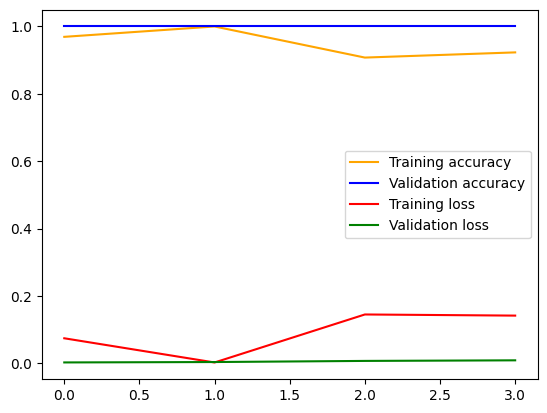

In [73]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

---

## 5. Test

#### ⏩ Create the *Test* dataset ⏩

For each test image, we will also create Grad-CAM and SmoothGrad explanatory visualizations, using the [tf-explain](https://github.com/sicara/tf-explain) library.

On Colab run the followi[link text](https://)ng %tensorflow_version line magic function to set tensorflow to v2.

In [52]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [54]:
import tensorflow as tf

print(tf.__version__)
tf.keras.backend.clear_session()

2.17.0


In [55]:
model = tf.keras.models.load_model('./model.keras')

In [ ]:
test_dataset = p.get_dataset_by_name('TEST2')
test_dataset.prepare()

#### 👀 Look at the results 👀


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


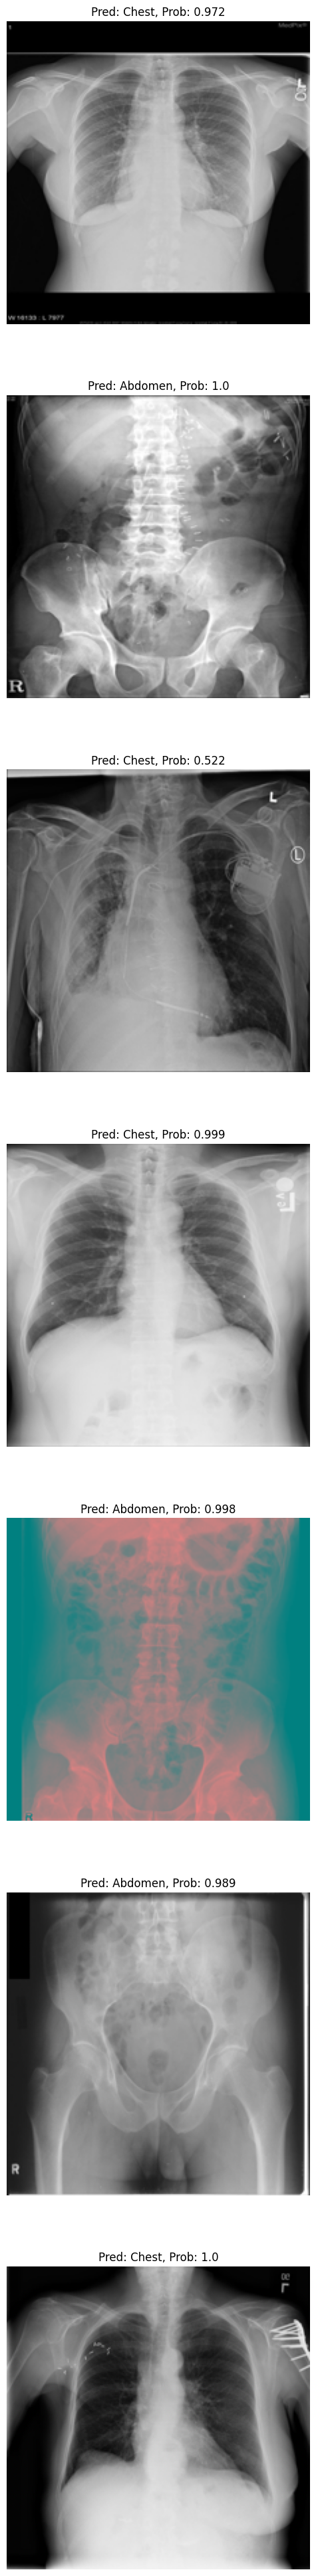

In [71]:
import numpy as np
from PIL import Image
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.smoothgrad import SmoothGrad
import cv2
import matplotlib.pyplot as plt

img_width = 224
img_height = 224

plt.figure(figsize=(20, 50))

for i, image_id in enumerate(test_dataset.image_ids):

    image = mdai.visualize.load_dicom_image(image_id, to_RGB=True)
    image = Image.fromarray(image)
    image = image.resize((img_width, img_height))

    X = np.empty((1, img_width, img_height, 3))
    X[0,:] = image
    y_prob = model.predict(X)
    y_classes = y_prob.argmax(axis=-1)

    pred_class = test_dataset.class_id_to_class_text(y_classes[0])
    pred_prob = y_prob[0][y_classes[0]]
    title = f'Pred: {pred_class}, Prob: {pred_prob:.3}'

    plt.subplot(len(test_dataset.image_ids), 3, i*3+1)
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')

plt.show()